In [24]:
import sys
print(sys.path)

print(os.getcwd())

['/Users/emilyolafson/GIT/stroke-graph-matching/jupyter_code', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python39.zip', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9/lib-dynload', '', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9/site-packages', '/Users/emilyolafson/miniforge3/envs/myenv/lib/python3.9/site-packages/IPython/extensions', '/Users/emilyolafson/.ipython']
/Users/emilyolafson/GIT/stroke-graph-matching/jupyter_code


['cov_day1.mat' 'cov_day10.mat' 'cov_day11.mat' 'cov_day12.mat'
 'cov_day13.mat' 'cov_day14.mat' 'cov_day15.mat' 'cov_day16.mat'
 'cov_day17.mat' 'cov_day18.mat' 'cov_day19.mat' 'cov_day2.mat'
 'cov_day20.mat' 'cov_day21.mat' 'cov_day22.mat' 'cov_day23.mat'
 'cov_day24.mat' 'cov_day25.mat' 'cov_day26.mat' 'cov_day27.mat'
 'cov_day28.mat' 'cov_day29.mat' 'cov_day3.mat' 'cov_day30.mat'
 'cov_day4.mat' 'cov_day5.mat' 'cov_day7.mat' 'cov_day8.mat'
 'cov_day9.mat']
mean trace34492.57014975189
mean norm10734.470927364648


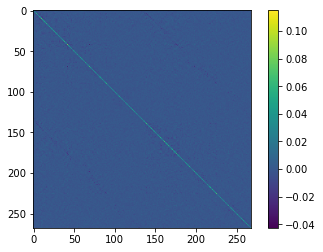

Inverse norm: 1.202556e+00
Regularized inv. norm: 1.061028e+00
Inverse norm: 1.077379e+00
Regularized inv. norm: 9.621460e-01
Inverse norm: 1.108298e+00
Regularized inv. norm: 9.876600e-01
Inverse norm: 1.036280e+00
Regularized inv. norm: 9.289053e-01
Inverse norm: 1.080782e+00
Regularized inv. norm: 9.655460e-01
Inverse norm: 1.063855e+00
Regularized inv. norm: 9.495023e-01
Inverse norm: 1.109584e+00
Regularized inv. norm: 9.872129e-01
Inverse norm: 1.059860e+00
Regularized inv. norm: 9.479510e-01
Inverse norm: 1.110105e+00
Regularized inv. norm: 9.870681e-01
Inverse norm: 1.092166e+00
Regularized inv. norm: 9.725342e-01
Inverse norm: 1.115395e+00
Regularized inv. norm: 9.918956e-01
Inverse norm: 1.399371e+00
Regularized inv. norm: 1.211341e+00
Inverse norm: 1.107734e+00
Regularized inv. norm: 9.853518e-01
Inverse norm: 1.120476e+00
Regularized inv. norm: 9.966840e-01
Inverse norm: 1.075079e+00
Regularized inv. norm: 9.615084e-01
Inverse norm: 1.056733e+00
Regularized inv. norm: 9.443

Regularized inv. norm: 1.419670e-01
Inverse norm: 1.120476e+00
Regularized inv. norm: 1.419844e-01
Inverse norm: 1.075079e+00
Regularized inv. norm: 1.413913e-01
Inverse norm: 1.056733e+00
Regularized inv. norm: 1.399558e-01
Inverse norm: 1.138274e+00
Regularized inv. norm: 1.425806e-01
Inverse norm: 1.186496e+00
Regularized inv. norm: 1.437095e-01
Inverse norm: 1.150931e+00
Regularized inv. norm: 1.432980e-01
Inverse norm: 1.145212e+00
Regularized inv. norm: 1.424271e-01
Inverse norm: 1.125374e+00
Regularized inv. norm: 1.421509e-01
Inverse norm: 1.109912e+00
Regularized inv. norm: 1.413266e-01
Inverse norm: 1.168418e+00
Regularized inv. norm: 1.433077e-01
Inverse norm: 1.088027e+00
Regularized inv. norm: 1.410284e-01
Inverse norm: 1.126563e+00
Regularized inv. norm: 1.423230e-01
Inverse norm: 1.139182e+00
Regularized inv. norm: 1.412809e-01
Inverse norm: 1.126605e+00
Regularized inv. norm: 1.421833e-01
Inverse norm: 1.161743e+00
Regularized inv. norm: 1.429909e-01
Inverse norm: 1.076

Inverse norm: 1.063855e+00
Regularized inv. norm: 7.252670e-02
Inverse norm: 1.109584e+00
Regularized inv. norm: 7.303125e-02
Inverse norm: 1.059860e+00
Regularized inv. norm: 7.252247e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 7.293737e-02
Inverse norm: 1.092166e+00
Regularized inv. norm: 7.288009e-02
Inverse norm: 1.115395e+00
Regularized inv. norm: 7.300779e-02
Inverse norm: 1.399371e+00
Regularized inv. norm: 7.501349e-02
Inverse norm: 1.107734e+00
Regularized inv. norm: 7.303992e-02
Inverse norm: 1.120476e+00
Regularized inv. norm: 7.297381e-02
Inverse norm: 1.075079e+00
Regularized inv. norm: 7.284376e-02
Inverse norm: 1.056733e+00
Regularized inv. norm: 7.230388e-02
Inverse norm: 1.138274e+00
Regularized inv. norm: 7.318178e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 7.359153e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 7.343485e-02
Inverse norm: 1.145212e+00
Regularized inv. norm: 7.309415e-02
Inverse norm: 1.125374e+00
Regularized inv. norm: 7.300

Regularized inv. norm: 5.290713e-02
Inverse norm: 1.139182e+00
Regularized inv. norm: 5.260851e-02
Inverse norm: 1.126605e+00
Regularized inv. norm: 5.293182e-02
Inverse norm: 1.161743e+00
Regularized inv. norm: 5.299955e-02
Inverse norm: 1.076096e+00
Regularized inv. norm: 5.244570e-02
group_prec norm: 9.402803e-01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
mean rmse: 2.617230e-01
Inverse norm: 1.202556e+00
Regularized inv. norm: 4.985129e-02
Inverse norm: 1.077379e+00
Regularized inv. norm: 4.930737e-02
Inverse norm: 1.108298e+00
Regularized inv. norm: 4.952302e-02
Inverse norm: 1.036280e+00
Regularized inv. norm: 4.920075e-02
Inverse norm: 1.080782e+00
Regularized inv. norm: 4.941150e-02
Inverse norm: 1.063855e+00
Regularized inv. norm: 4.928955e-02
Inverse norm: 1.109584e+00
Regularized inv. norm: 4.956002e-02
Inverse norm: 1.059860e+00
Regularized inv. norm: 4.928361e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 4.949391e-02
Inverse norm: 

Regularized inv. norm: 3.938915e-02
Inverse norm: 1.063855e+00
Regularized inv. norm: 3.931207e-02
Inverse norm: 1.109584e+00
Regularized inv. norm: 3.949976e-02
Inverse norm: 1.059860e+00
Regularized inv. norm: 3.930705e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 3.944714e-02
Inverse norm: 1.092166e+00
Regularized inv. norm: 3.943590e-02
Inverse norm: 1.115395e+00
Regularized inv. norm: 3.946479e-02
Inverse norm: 1.399371e+00
Regularized inv. norm: 4.013387e-02
Inverse norm: 1.107734e+00
Regularized inv. norm: 3.948376e-02
Inverse norm: 1.120476e+00
Regularized inv. norm: 3.943560e-02
Inverse norm: 1.075079e+00
Regularized inv. norm: 3.941418e-02
Inverse norm: 1.056733e+00
Regularized inv. norm: 3.919724e-02
Inverse norm: 1.138274e+00
Regularized inv. norm: 3.951167e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 3.967803e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 3.960552e-02
Inverse norm: 1.145212e+00
Regularized inv. norm: 3.946725e-02
Inverse norm: 1.125

Regularized inv. norm: 3.136164e-02
Inverse norm: 1.080782e+00
Regularized inv. norm: 3.145847e-02
Inverse norm: 1.063855e+00
Regularized inv. norm: 3.141005e-02
Inverse norm: 1.109584e+00
Regularized inv. norm: 3.154064e-02
Inverse norm: 1.059860e+00
Regularized inv. norm: 3.140624e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 3.149925e-02
Inverse norm: 1.092166e+00
Regularized inv. norm: 3.149315e-02
Inverse norm: 1.115395e+00
Regularized inv. norm: 3.150915e-02
Inverse norm: 1.399371e+00
Regularized inv. norm: 3.195505e-02
Inverse norm: 1.107734e+00
Regularized inv. norm: 3.152356e-02
Inverse norm: 1.120476e+00
Regularized inv. norm: 3.148502e-02
Inverse norm: 1.075079e+00
Regularized inv. norm: 3.147640e-02
Inverse norm: 1.056733e+00
Regularized inv. norm: 3.132135e-02
Inverse norm: 1.138274e+00
Regularized inv. norm: 3.153667e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 3.165714e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 3.160298e-02
Inverse norm: 1.145

Inverse norm: 1.138274e+00
Regularized inv. norm: 2.716659e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 2.726406e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 2.721984e-02
Inverse norm: 1.145212e+00
Regularized inv. norm: 2.713898e-02
Inverse norm: 1.125374e+00
Regularized inv. norm: 2.711663e-02
Inverse norm: 1.109912e+00
Regularized inv. norm: 2.703414e-02
Inverse norm: 1.168418e+00
Regularized inv. norm: 2.717584e-02
Inverse norm: 1.088027e+00
Regularized inv. norm: 2.711004e-02
Inverse norm: 1.126563e+00
Regularized inv. norm: 2.712648e-02
Inverse norm: 1.139182e+00
Regularized inv. norm: 2.700763e-02
Inverse norm: 1.126605e+00
Regularized inv. norm: 2.714883e-02
Inverse norm: 1.161743e+00
Regularized inv. norm: 2.715349e-02
Inverse norm: 1.076096e+00
Regularized inv. norm: 2.697260e-02
group_prec norm: 9.402803e-01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
mean rmse: 2.646094e-01
Inverse norm: 1.202556e+00
Regularized inv. norm: 

Regularized inv. norm: 2.309648e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 2.314894e-02
Inverse norm: 1.092166e+00
Regularized inv. norm: 2.314597e-02
Inverse norm: 1.115395e+00
Regularized inv. norm: 2.315297e-02
Inverse norm: 1.399371e+00
Regularized inv. norm: 2.340822e-02
Inverse norm: 1.107734e+00
Regularized inv. norm: 2.316228e-02
Inverse norm: 1.120476e+00
Regularized inv. norm: 2.313554e-02
Inverse norm: 1.075079e+00
Regularized inv. norm: 2.313467e-02
Inverse norm: 1.056733e+00
Regularized inv. norm: 2.303711e-02
Inverse norm: 1.138274e+00
Regularized inv. norm: 2.316498e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 2.324280e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 2.320761e-02
Inverse norm: 1.145212e+00
Regularized inv. norm: 2.314280e-02
Inverse norm: 1.125374e+00
Regularized inv. norm: 2.312443e-02
Inverse norm: 1.109912e+00
Regularized inv. norm: 2.306063e-02
Inverse norm: 1.168418e+00
Regularized inv. norm: 2.316926e-02
Inverse norm: 1.088

Regularized inv. norm: 2.070417e-02
Inverse norm: 1.056733e+00
Regularized inv. norm: 2.062172e-02
Inverse norm: 1.138274e+00
Regularized inv. norm: 2.072759e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 2.079415e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 2.076439e-02
Inverse norm: 1.145212e+00
Regularized inv. norm: 2.070869e-02
Inverse norm: 1.125374e+00
Regularized inv. norm: 2.069261e-02
Inverse norm: 1.109912e+00
Regularized inv. norm: 2.063948e-02
Inverse norm: 1.168418e+00
Regularized inv. norm: 2.072957e-02
Inverse norm: 1.088027e+00
Regularized inv. norm: 2.069753e-02
Inverse norm: 1.126563e+00
Regularized inv. norm: 2.069994e-02
Inverse norm: 1.139182e+00
Regularized inv. norm: 2.061958e-02
Inverse norm: 1.126605e+00
Regularized inv. norm: 2.071801e-02
Inverse norm: 1.161743e+00
Regularized inv. norm: 2.071803e-02
Inverse norm: 1.076096e+00
Regularized inv. norm: 2.060228e-02
group_prec norm: 9.402803e-01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

Inverse norm: 1.139182e+00
Regularized inv. norm: 1.866364e-02
Inverse norm: 1.126605e+00
Regularized inv. norm: 1.874946e-02
Inverse norm: 1.161743e+00
Regularized inv. norm: 1.874883e-02
Inverse norm: 1.076096e+00
Regularized inv. norm: 1.865055e-02
group_prec norm: 9.402803e-01
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
mean rmse: 2.653450e-01
Inverse norm: 1.202556e+00
Regularized inv. norm: 1.836960e-02
Inverse norm: 1.077379e+00
Regularized inv. norm: 1.826887e-02
Inverse norm: 1.108298e+00
Regularized inv. norm: 1.831667e-02
Inverse norm: 1.036280e+00
Regularized inv. norm: 1.825841e-02
Inverse norm: 1.080782e+00
Regularized inv. norm: 1.829783e-02
Inverse norm: 1.063855e+00
Regularized inv. norm: 1.828253e-02
Inverse norm: 1.109584e+00
Regularized inv. norm: 1.833689e-02
Inverse norm: 1.059860e+00
Regularized inv. norm: 1.828107e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 1.831469e-02
Inverse norm: 1.092166e+00
Regularized inv. norm: 

Regularized inv. norm: 1.673510e-02
Inverse norm: 1.109584e+00
Regularized inv. norm: 1.678219e-02
Inverse norm: 1.059860e+00
Regularized inv. norm: 1.673389e-02
Inverse norm: 1.110105e+00
Regularized inv. norm: 1.676224e-02
Inverse norm: 1.092166e+00
Regularized inv. norm: 1.676031e-02
Inverse norm: 1.115395e+00
Regularized inv. norm: 1.676344e-02
Inverse norm: 1.399371e+00
Regularized inv. norm: 1.690554e-02
Inverse norm: 1.107734e+00
Regularized inv. norm: 1.676893e-02
Inverse norm: 1.120476e+00
Regularized inv. norm: 1.675179e-02
Inverse norm: 1.075079e+00
Regularized inv. norm: 1.675306e-02
Inverse norm: 1.056733e+00
Regularized inv. norm: 1.669337e-02
Inverse norm: 1.138274e+00
Regularized inv. norm: 1.676709e-02
Inverse norm: 1.186496e+00
Regularized inv. norm: 1.681653e-02
Inverse norm: 1.150931e+00
Regularized inv. norm: 1.679543e-02
Inverse norm: 1.145212e+00
Regularized inv. norm: 1.675340e-02
Inverse norm: 1.125374e+00
Regularized inv. norm: 1.674087e-02
Inverse norm: 1.109

In [109]:
# adapted from Zijin Gu: https://github.com/zijin-gu/scfc-coupling
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

cwd = os.getcwd()
data_dir = '28andme'
roi_number = 268

def extract_fc_prec():
    fc_dir =data_dir + '/covariance/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    print(subj_all)
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    trace=[]
    norm=[]
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C'] # need to use covariance
        trace.append(np.trace(fccov['C']))
        norm.append(np.linalg.norm(fccov['C']))
        n = n+1
        
    print("mean trace" + str(np.mean(trace)))
    print("mean norm" + str(np.mean(norm)))
    
    # regularized precision calculation
    min_rmse = 1e5
    opt_gamma = 0
    allrmse=[]
    
    plt.imshow(np.linalg.inv(fc_corr[0]))
    plt.colorbar()
    plt.show()
    
    
    for gamma in np.linspace(1, 1000,50): #for all gamma values
        inverse = []
        reg_inv = []
        
        for i in range(subj_all.shape[0]): #calculate the unregularized inverse and regularized inverse for a given gamma
            inverse.append(np.linalg.inv(fc_corr[i]))
            print("Inverse norm: " + str("{:e}".format(np.linalg.norm(np.linalg.inv(fc_corr[i])))))
            reg_inv.append(np.linalg.inv(fc_corr[i] + gamma*np.eye(roi_number)))
            print("Regularized inv. norm: " + str("{:e}".format(np.linalg.norm(np.linalg.inv(fc_corr[i] + gamma*np.eye(roi_number))))))

        group_prec = np.mean(inverse, axis=0) #calculate the mean unregularized inverse across subjects
        print("group_prec norm: " + str("{:e}".format(np.linalg.norm(group_prec))))
        
        diff = []

        # for each subject, calculate the difference between the regularized inverse and group average unregularized inverse.
        for i in range(subj_all.shape[0]):
            print(i)
            diff.append(np.linalg.norm(reg_inv[i][np.triu_indices(roi_number,1)] - group_prec[np.triu_indices(roi_number,1)]))
        rmse = np.mean(diff) #mean difference across subjects
        allrmse.append(rmse)
        print("mean rmse: " + str("{:e}".format(np.mean(rmse))))

        if rmse < min_rmse:
            min_rmse = rmse
            opt_gamma = gamma 
            

    fc_prec = np.zeros([subj_all.shape[0],roi_number,roi_number])
    
    #now calculate regularized inversion matrices based on optimal gamma (should be lambda).
    for i in range(subj_all.shape[0]):
        fc_prec[i] = np.linalg.inv(fc_corr[i] + opt_gamma*np.eye(roi_number))

    mdic = {"C": fc_prec, "gamma": opt_gamma, "rmse":allrmse, "sub_sessID": subj_all}
    output_dir =data_dir + '/precision/'

    sio.savemat(output_dir + 'FCprec_concat_allsub.mat', mdic)
    
for sess in range(0,1):
    extract_fc_prec()
    #extract_fc_corr()
    


In [96]:
print(np.linspace(1e14, 1e15,50))

[1.00000000e+14 1.18367347e+14 1.36734694e+14 1.55102041e+14
 1.73469388e+14 1.91836735e+14 2.10204082e+14 2.28571429e+14
 2.46938776e+14 2.65306122e+14 2.83673469e+14 3.02040816e+14
 3.20408163e+14 3.38775510e+14 3.57142857e+14 3.75510204e+14
 3.93877551e+14 4.12244898e+14 4.30612245e+14 4.48979592e+14
 4.67346939e+14 4.85714286e+14 5.04081633e+14 5.22448980e+14
 5.40816327e+14 5.59183673e+14 5.77551020e+14 5.95918367e+14
 6.14285714e+14 6.32653061e+14 6.51020408e+14 6.69387755e+14
 6.87755102e+14 7.06122449e+14 7.24489796e+14 7.42857143e+14
 7.61224490e+14 7.79591837e+14 7.97959184e+14 8.16326531e+14
 8.34693878e+14 8.53061224e+14 8.71428571e+14 8.89795918e+14
 9.08163265e+14 9.26530612e+14 9.44897959e+14 9.63265306e+14
 9.81632653e+14 1.00000000e+15]


[1.00000000e-01 3.50964787e+02 7.01829575e+02 1.05269436e+03
 1.40355915e+03 1.75442394e+03 2.10528872e+03 2.45615351e+03
 2.80701830e+03 3.15788309e+03 3.50874787e+03 3.85961266e+03
 4.21047745e+03 4.56134223e+03 4.91220702e+03 5.26307181e+03
 5.61393660e+03 5.96480138e+03 6.31566617e+03 6.66653096e+03
 7.01739575e+03 7.36826053e+03 7.71912532e+03 8.06999011e+03
 8.42085489e+03 8.77171968e+03 9.12258447e+03 9.47344926e+03
 9.82431404e+03 1.01751788e+04 1.05260436e+04 1.08769084e+04
 1.12277732e+04 1.15786380e+04 1.19295028e+04 1.22803676e+04
 1.26312323e+04 1.29820971e+04 1.33329619e+04 1.36838267e+04
 1.40346915e+04 1.43855563e+04 1.47364211e+04 1.50872859e+04
 1.54381506e+04 1.57890154e+04 1.61398802e+04 1.64907450e+04
 1.68416098e+04 1.71924746e+04]
RMSE
[[0.36530307 0.21474914 0.2320978  0.24212351 0.24806105 0.25189304
  0.25453614 0.25645227 0.25789541 0.25901547 0.2599061  0.26062855
  0.26122445 0.261723   0.26214522 0.2625066  0.26281881 0.26309077
  0.26332941 0.2635402  0.2

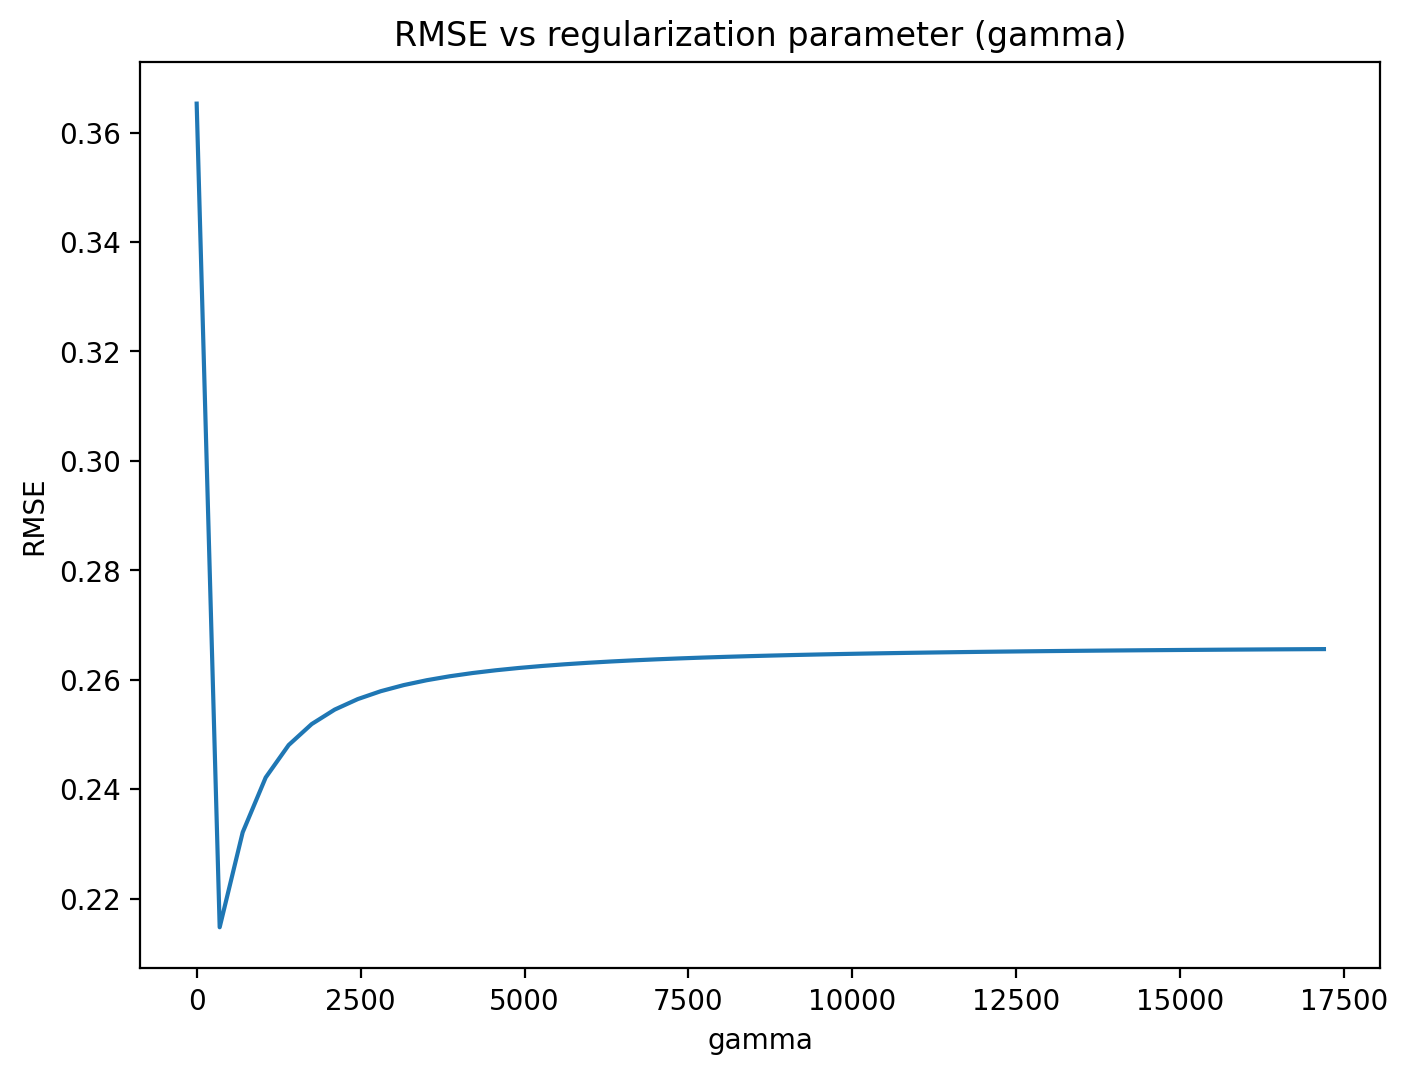

In [110]:
cwd = os.getcwd()
data_dir = '28andme'
fc_dir =data_dir + '/precision/'
output_prec = sio.loadmat(fc_dir + 'FCprec_concat_allsub.mat')
rmse = output_prec['rmse'] 
opt_gamma = output_prec['gamma'] 

n = 0

fc_dir =data_dir + '/covariance/'
subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
for subj in subj_all:
    fccov = sio.loadmat(fc_dir + str(subj))
    fc_corr[n] = fccov['C'] # need to use covariance

gridsearch=np.linspace(0.1, np.linalg.norm(fccov['C']),50)
print(gridsearch)
figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

plt.plot(gridsearch,rmse.transpose())
plt.ylabel('RMSE')
plt.xlabel('gamma')
print("RMSE")
print(rmse)

plt.title('RMSE vs regularization parameter (gamma)')
#plt.text(opt_gamma-0.3, 0.5, 'optimal gamma = ' + str(opt_gamma[0][0]))

data_dir = '28andme/'
plt.savefig(data_dir + 'optimal_gamma.png')